# Feature Selection, Data Preprocessing, and ML Model Fitting

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use('fast')

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error 



### Data Importation and Cleansing

In [2]:
# Read Data In
try: 
    books_df = pd.read_csv('books.csv')
except:
    books_df = pd.read_csv('books.csv', on_bad_lines='warn')
    
#remove leading spaces in front of num_paages
books_df.rename(columns={"  num_pages":"num_pages"}, inplace=True)

#Convert publication date to date object
books_df['publication_date'] = pd.to_datetime(books_df['publication_date'], format = "%m/%d/%Y", errors='coerce')


#convert isbn_13 to type object
books_df['isbn13'] =books_df['isbn13'].astype('object')

#convert book_id to type object
books_df['bookID'] = books_df['bookID'].astype('object')

# Split the authors column into a list of individual author names
books_df['authors'] = books_df['authors'].str.split('/')


# Drop the 2 cases where publication date is missing
books_df = books_df.loc[~books_df.publication_date.isna()]


b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


### Feature Engineering and Selection


#### Feature Engineering

1. We create 2 features related to the publication date; year and month.
2. From the insight that some book titles appear multiple times, a occurrences count feature is created.
3. Title word count.

In [3]:
# Month of publication feature
books_df['pub_month'] = pd.DatetimeIndex(books_df.publication_date).month

# Year of Publication feature
books_df['pub_year'] = pd.DatetimeIndex(books_df.publication_date).year


# feature which has the number of occurences of each title
books_df['occ_count'] = books_df.groupby('title')['title'].transform('count') 

# Title Word Count
books_df['title_word_count'] = (books_df['title'].str.split(" ")).map(lambda w: len(w))


# Create count of authors for each book
books_df['author_count'] = books_df['authors'].map(lambda a: len(a))



#### Feature Encoding

Authors and publishers that have published more than 5 books are one-hot encoded, as well as the language codes.

In [4]:
# Get authors that have written or contributed to more than 5 books
exploded_authors = books_df.explode('authors')['authors']
multiple_book_authors = exploded_authors.value_counts()[exploded_authors.value_counts() > 5].index.array

#One-hot encode Authors with more than 5 books
mlb = MultiLabelBinarizer()
authors_onehot_df = pd.DataFrame(mlb.fit_transform(books_df['authors']),columns=mlb.classes_)
authors_onehot_df = authors_onehot_df[multiple_book_authors]
books_df = pd.concat([books_df, authors_onehot_df], axis=1 )
books_df.drop(columns=['authors'], inplace=True)




#One-hot encode publishers with more than 5 books
publisher_book_counts = books_df['publisher'].value_counts()
multiple_book_publishers = publisher_book_counts[publisher_book_counts > 5].index.array
multiple_book_publishers = "publisher_" + multiple_book_publishers

encoder = OneHotEncoder(handle_unknown='ignore')
publisher_onehot = encoder.fit_transform(books_df[['publisher']])
publisher_onehot_df = pd.DataFrame(publisher_onehot.toarray(), columns=encoder.get_feature_names(['publisher']))

#Select only columns where publisher has more than 3 books
publisher_onehot_df = publisher_onehot_df[multiple_book_publishers]

# Concatenate the one-hot encoding dataframe with the original dataframe
books_df = pd.concat([books_df, publisher_onehot_df], axis=1)

# Drop the original publisher column
books_df.drop(columns=['publisher'], inplace=True)




#one-hot encode language code
language_code_onehot = encoder.fit_transform(books_df[['language_code']])
language_code_onehot_df = pd.DataFrame(language_code_onehot.toarray(), columns=encoder.get_feature_names(['language_code']))

# Concatenate the one-hot encoding dataframe with the original dataframe
books_df = pd.concat([books_df, language_code_onehot_df], axis=1)

# Drop the original language code column
books_df.drop(columns=['language_code'], inplace=True)


/Users/gbolahanomotosho/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/gbolahanomotosho/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
books_df.dropna(inplace=True)

#### Feature Selection

`bookId`, `title`, `isbn`, and `isbn13` are dropped because they do not add any predictive power to any model by their very definition. Two features that fit into ML models have been dervied from `publication_date`, so it is also dropped. This leaves us with the following variables;

1. **num_pages**: From the exploratory analysis, we established that there was a positive relationship between the number of pages in a book and it's average rating, though not entirely linear.

2. **ratings_count and text_reviews**: We also established a similar relationship to that of `num_pages` and `average_rating` between `ratings_count` and `average_rating`. Similary for `text_reviews` as well.

3. **pub_month and pub_year**: These were derived from publication date, and we established from the exploratory analysis that it possesses predictive power due to how average ratings vary with publication date.

4. **title_word_count**: From the EDA, this appears to have some predictive power.

5. **author_count**:  From the EDA, this appears to have some predictive power.

6. **author(s)**: We expect that authors of great titles would continue to create other great titles. As opposed to one variable, this has been one-hot encoded creating a column for each author (who has contributed to at least 5 books)

7. **language_code**: We also established that the language code appears to have some predictive power w.r.t average_ratings. 

8. **publisher**:The rationale behind this is that top publishers have stricter criteria for publishing a book, hence a higer quality book, with the reverse also being the case for lower quality books.

In [6]:
label = books_df['average_rating'].values
books_df.drop(['bookID', 'title', 'isbn', 'isbn13', 'average_rating','publication_date'], axis=1, inplace=True)

### Split data into Training, Test, and Validation Sets

In [7]:
books_df.describe()

,num_pages,ratings_count,text_reviews_count,pub_month,pub_year,occ_count,title_word_count,author_count,Stephen King,William Shakespeare,...,language_code_nor,language_code_por,language_code_rus,language_code_spa,language_code_srp,language_code_swe,language_code_tur,language_code_wel,language_code_zho,language_code_nan
count,11119.000000,1.111900e+04,11119.000000,11119.000000,11119.00000,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,...,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,11119.000000,11119.0
mean,336.340948,1.794827e+04,542.202806,6.548071,2000.16953,1.241389,6.291033,1.729652,0.008904,0.008364,...,0.000090,0.000899,0.000180,0.019606,0.000090,0.000180,0.000090,0.000090,0.001259,0.0
std,241.149105,1.125190e+05,2577.069155,3.413992,8.24647,0.875200,4.168128,1.820397,0.093943,0.091076,...,0.009483,0.029977,0.013411,0.138649,0.009483,0.013411,0.009483,0.009483,0.035463,0.0
min,0.000000,0.000000e+00,0.000000,1.000000,1900.00000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,192.000000,1.040000e+02,9.000000,4.000000,1998.00000,1.000000,3.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,299.000000,7.450000e+02,47.000000,7.000000,2003.00000,1.000000,5.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,416.000000,5.000500e+03,238.000000,10.000000,2005.00000,1.000000,8.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,6576.000000,4.597666e+06,94265.000000,12.000000,2020.00000,9.000000,49.000000,51.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [8]:

book_df=StandardScaler().fit_transform(books_df)

# Split the Data into 75% Training, 25% Testing
X_train, X_test, y_train, y_test = train_test_split(books_df, label, test_size=0.25)
k_fold = list(KFold(n_splits=5, shuffle=True).split(X_train, y_train))

### Parameter Tuning and Model Scoring Functions

In [9]:
def grid_search_best_model(model, params, k_fold, X_train, y_train):
    grid_search = GridSearchCV(model,
                           params,                             
                          cv=k_fold).fit(X_train,y_train)
    print("Best params", grid_search.best_params_)
    print("Best estimator", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

model_results = {}

def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
    y_pred = model.predict(X_test)  
    print(f"Training score: {model.score(X_train,y_train)}")
    print(f"Test score: {r2_score(y_test, y_pred)}")
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
    if show_plot == True:
        predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
    print(predictions_comparision.sample(10))    
    
    
    return {
        "training_score": model.score(X_train,y_train),
        "test_score_r2" : r2_score(y_test, y_pred),
        "test_score_mse" : mean_squared_error(y_test, y_pred)
    }

def compare_results():
    for key in model_results:
        print("Regression: ", key)
        print("Trainign score", model_results[key]["training_score"])
        print("R2 Test score ", model_results[key]["test_score_r2"])
        print("MSE Test score ", model_results[key]["test_score_mse"])
        print()

Best params {'fit_intercept': True}
Best estimator LinearRegression()
Best score: -1265296570445.6553
Training score: 0.2559292553033137
Test score: 0.0717080519247385
MSE:  0.12312346777174628
      Actual  Predicted
2532    3.50   4.186090
2074    3.68   3.436895
1481    3.99   3.896993
473     3.67   3.876641
372     4.29   4.086731
560     3.65   3.960246
1757    3.83   4.103146
1027    3.56   3.877394
1207    3.80   3.894906
1608    3.95   3.986218


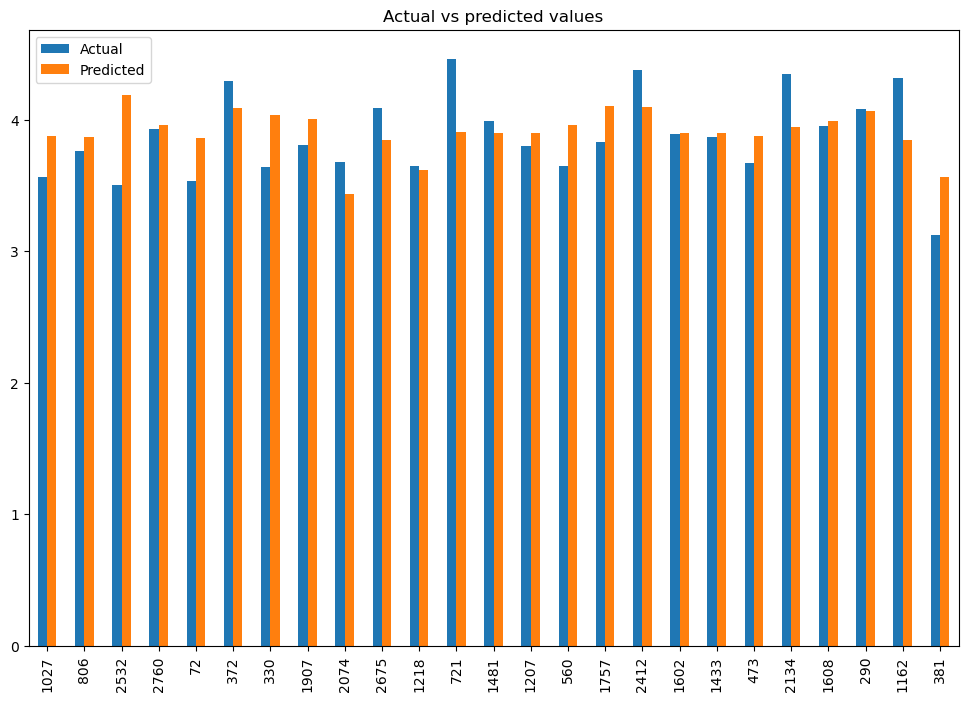

In [10]:
params={
    "fit_intercept":[True,False],
}

linear_regression = grid_search_best_model(LinearRegression(), params, k_fold, X_train, y_train)
model_results["linear_regression"] = score_model(linear_regression, X_train, X_test, y_train, y_test)

Best params {'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_leaf': 30, 'min_samples_split': 40}
Best estimator DecisionTreeRegressor(max_depth=6, max_leaf_nodes=20, min_samples_leaf=30,
                      min_samples_split=40)
Best score: 0.11904655437379519
Training score: 0.16199767292621425
Test score: 0.18081427987004195
MSE:  0.10865222608105433
      Actual  Predicted
291     3.56   4.165271
1213    3.83   3.804873
1676    4.17   3.994667
1807    3.90   4.220246
1821    3.96   3.981568
1257    3.76   3.856699
965     4.21   3.972708
2621    4.10   4.047048
1510    3.97   3.981568
2109    3.71   4.128119


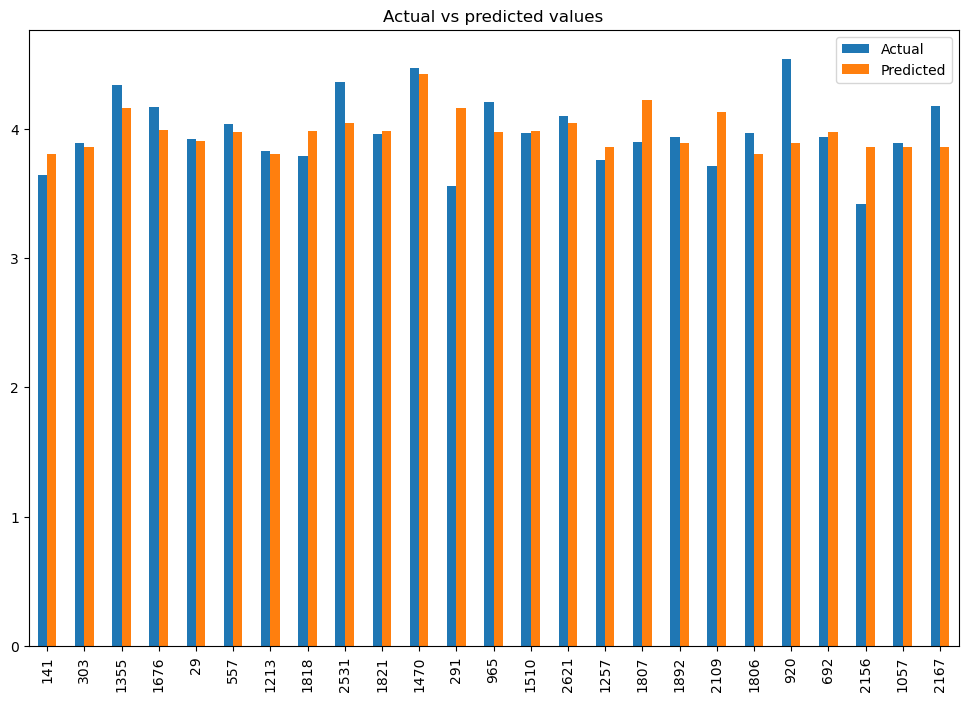

In [11]:
params = {    "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8, 15, 50],
              "min_samples_leaf": [5, 20, 30],
              "max_leaf_nodes": [5, 20],
              }
dtr = grid_search_best_model(DecisionTreeRegressor(), params, k_fold, X_train, y_train)
model_results["dtr"] = score_model(dtr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 0.5, 'n_estimators': 700}
Best estimator AdaBoostRegressor(learning_rate=0.5, n_estimators=700)
Best score: 0.04594304550194328
Training score: 0.14234693599865555
Test score: 0.1773703718579941
MSE:  0.10910900683629994
      Actual  Predicted
1361    4.12   3.914303
2023    3.65   3.897302
623     3.98   3.914303
1769    3.55   3.877394
1254    3.41   3.897302
2305    3.51   3.877394
2140    4.08   3.910241
2246    3.40   3.910241
2420    3.33   3.877394
2672    3.32   3.877394


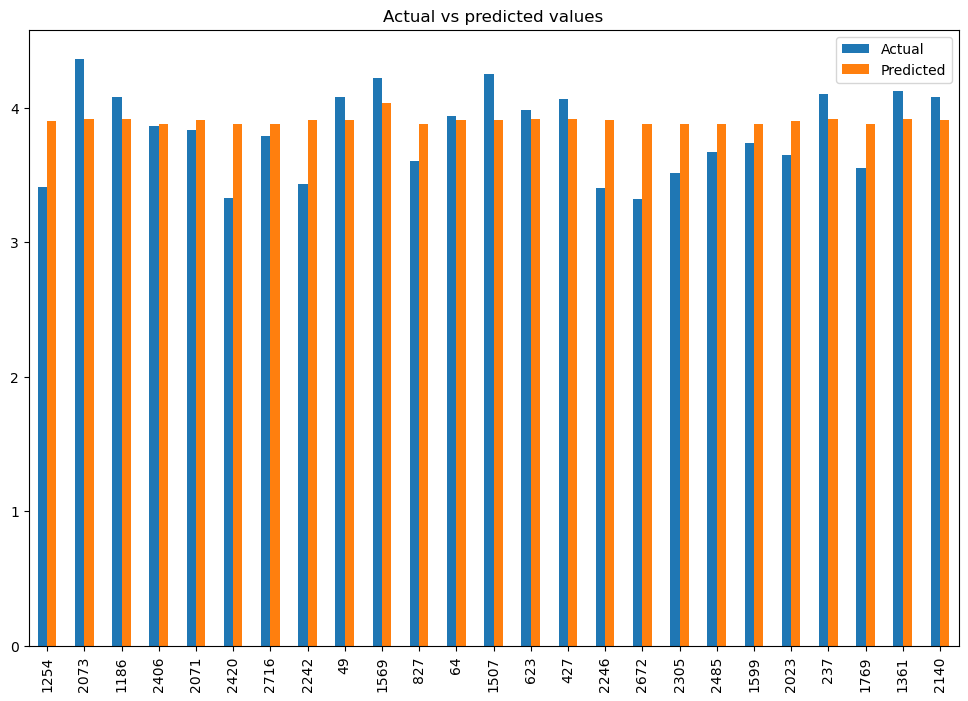

In [12]:
params = {"learning_rate":[0.3, 0.5,1],
          "n_estimators": [50, 100,200,400,700,1000]
              }
abr = grid_search_best_model(AdaBoostRegressor(), params, k_fold, X_train, y_train)
model_results["abr"] = score_model(abr, X_train, X_test, y_train, y_test)

Best params {'learning_rate': 0.3, 'max_depth': 3, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 100}
Best estimator GradientBoostingRegressor(learning_rate=0.3, max_features=0.3,
                          min_samples_leaf=5)
Best score: 0.20425815694722366
Training score: 0.34242056835948165
Test score: 0.2440110609736179
MSE:  0.10027015742515623
      Actual  Predicted
1248    4.00   3.822207
1412    4.22   4.055299
312     4.03   4.002833
1516    3.68   3.915849
1366    3.84   4.005607
2672    3.32   3.832445
1779    4.11   3.853322
110     2.80   3.742709
1871    3.97   3.922778
1472    4.16   3.940990


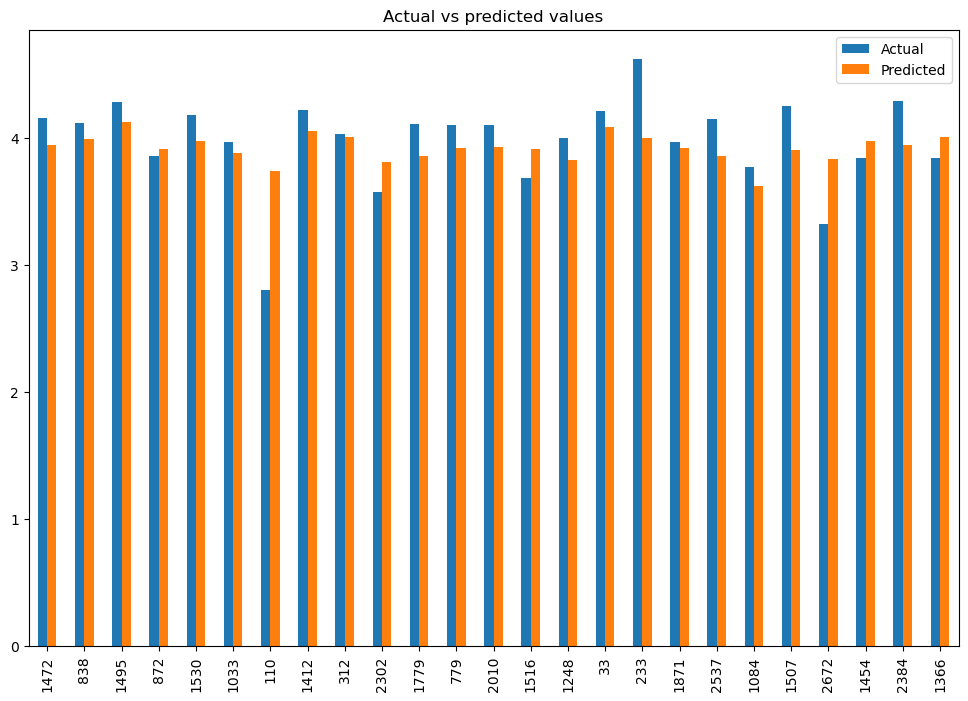

In [13]:
params={"n_estimators":[20, 50, 100,200], 
        "learning_rate": [0.01, 0.05, 0.1, 0.3],
         "max_depth":[3,5,10], 
        "min_samples_leaf": [3,5],
          "max_features": [0.3, 1]
       }        

gbr = grid_search_best_model(GradientBoostingRegressor(), params,k_fold, X_train, y_train)
model_results["gbr"] = score_model(gbr, X_train, X_test, y_train, y_test)

In [14]:
compare_results()

Regression:  linear_regression
Trainign score 0.2559292553033137
R2 Test score  0.0717080519247385
MSE Test score  0.12312346777174628

Regression:  dtr
Trainign score 0.16199767292621425
R2 Test score  0.18081427987004195
MSE Test score  0.10865222608105433

Regression:  abr
Trainign score 0.14234693599865555
R2 Test score  0.1773703718579941
MSE Test score  0.10910900683629994

Regression:  gbr
Trainign score 0.34242056835948165
R2 Test score  0.2440110609736179
MSE Test score  0.10027015742515623



From the output of compare_results() we find that the GradientBoostingRegressor performed best with an R2 score of 24.4% and had a training score of 34.24%.